In [1]:
# !pip install tensorflow-gpu==2.5.0
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Softmax, Multiply, Dense, concatenate, Dropout, Flatten, LSTM, BatchNormalization
from tensorflow.keras.activations import softmax
import numpy as np
from keras import backend as K
from keras.callbacks import ModelCheckpoint, History
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
training_set = np.load('/content/drive/My Drive/ME/datapre.npy')
traininglabels = np.load('/content/drive/My Drive/ME/labelspre.npy')

K.set_image_data_format('channels_last')
image_rows, image_columns, image_depth = 64, 64, 50
input_shape = (1, image_rows, image_columns, image_depth)
print(traininglabels.shape, training_set.shape)

(137, 8) (137, 1, 64, 64, 50)


In [52]:
###### 2 CHANNEL CNN MODEL - MAIN MODEL ###### 

# model = Sequential()
# model.add(Conv3D(32, (3, 3, 15), input_shape=input_shape, data_format='channels_first', activation='relu'))
# model.add(MaxPooling3D(pool_size=(3, 3, 3)))
# inputs = keras.Input(shape=(64,64,25,1,))
inputs = keras.Input(shape=input_shape)
c1 = Conv3D(32, (3, 3, 15), input_shape=input_shape, data_format='channels_first', activation='relu', padding='same')(inputs)
c2 = Conv3D(32, (3, 3, 15), input_shape=input_shape, data_format='channels_first', activation='relu', padding='same')(inputs)
mp1 = MaxPooling3D(pool_size=(3,3,3), padding='same')(c1)
mp2 = MaxPooling3D(pool_size=(3,3,3), padding='same')(c2)
sm = Softmax()
o1 = sm(mp1)
o2 = sm(mp2)
mul1 = Multiply()([o2, mp1])
mul2 = Multiply()([o1, mp2])
drop1 = Dropout(0.4)(mul1)
drop2 = Dropout(0.4)(mul2)
f1 = Flatten()(drop1)
f2 = Flatten()(drop2)
merged_layer = concatenate([f1, f2])
dense1 = Dense(128, activation='relu')(merged_layer)
drop = Dropout(0.4)(dense1)
dense2 = Dense(8, activation='relu', name='dense2')(drop)
softmax_output = softmax(dense2)
# softmax_output = Softmax()(dense2)
model = Model(inputs, softmax_output)
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
keras.utils.plot_model(model, "Model.png", show_shapes=True)
# model.summary()

In [50]:
###### FEATURE EXTRACTION MODEL - 1st CHILD MODEL ######

l1 = Conv2D(32, (3,3), input_shape = (64, 64, 1), activation = 'relu', padding='same')(dense2)
l2 = MaxPooling2D(pool_size = (2,2), padding='same')(l1)
l3 = Dropout(0.05)(l2)
l4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(l3)
l5 = MaxPooling2D(pool_size = (2,2), padding='same')(l4)
l6 = Dropout(0.35)(l5)
l7 = Flatten(name='flatten')(l6)
l8 = Dense(200,activation = 'relu')(l7)
l9 = Dense(8, activation = 'softmax', name='dense')(l8)
model1 = Model(inputs, l9)
model1.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer= 'adam', metrics = ['accuracy'])

# model1 = Sequential()
# model1.add(Conv2D(32, (3,3), input_shape = (64, 64, 1), activation = 'relu', padding='same'))
# model1.add(MaxPooling2D(pool_size = (2,2), padding='same'))
# model1.add(Dropout(0.05))
# model1.add(Conv2D(64, (3,3), activation = 'relu', padding='same'))
# model1.add(MaxPooling2D(pool_size = (2,2), padding='same'))
# model1.add(Dropout(0.35))
# model1.add(Flatten(name='flatten'))
# model1.add(Dense(200,activation = 'relu'))
# model1.add(Dense(8, activation = 'softmax', name='dense'))
# model1.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer= 'adam', metrics = ['accuracy'])


# model1.summary()

ValueError: ignored

In [13]:
###### 1st TRAIN CHILD MODEL ######

X_train, X_test, y_train, y_test = train_test_split(training_set,traininglabels,test_size=0.2, random_state = 42)
# X_train = np.reshape(X_train,(X_train.shap*50,64,64))
X_train = np.reshape(X_train,(X_train.shape[0]*50,X_train.shape[2],X_train.shape[3],1))
X_test = np.reshape(X_test,(X_test.shape[0]*50,X_test.shape[2],X_test.shape[3],1))
y_labels = np.zeros((y_train.shape[0]*50,8))
k = 0
#print(y_train.shape,y_labels.shape,X_train.shape)
for i in range(y_train.shape[0]):
    y_labels[k:k+50] = y_train[i]
    k += 50
print(y_labels.shape,y_labels[0])

#X_test = np.reshape(X_test,(X_test.shape[0]*50,X_test.shape[2],X_test.shape[3],1))
y_labels_test = np.zeros((y_test.shape[0]*50,8))
k = 0
print(y_test.shape,y_labels_test.shape,X_test.shape)

for i in range(y_test.shape[0]):
    y_labels_test[k:k+50] = y_test[i]
    k += 50
print(X_test.shape,y_labels_test.shape,y_labels_test[0])

(5450, 8) [0. 0. 0. 0. 0. 0. 0. 1.]
(28, 8) (1400, 8) (1400, 64, 64, 1)
(1400, 64, 64, 1) (1400, 8) [0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
model1.fit(X_train, y_labels, validation_data=(X_test,y_labels_test), epochs=50, batch_size=50)

In [47]:
modelfeatured1 = Model(
    inputs=model1.input,
    outputs=model1.get_layer('dense').output
)

modelfeatured2 = Model(
    inputs=model1.input,
    outputs=model1.get_layer('flatten').output
)

m_op = model.get_layer('softmax_output').output
test = Model(inputs, model1.get_layer('dense').output)

ValueError: ignored

In [27]:
X_train_features = modelfeatured1.predict(X_train)
X_test_features = modelfeatured1.predict(X_test)

In [28]:
X_train_features = np.reshape(X_train_features,(int(X_train_features.shape[0]/50),50,200))
X_test_features = np.reshape(X_test_features,(int(X_test_features.shape[0]/50),50,200))
X_train_features.shape,X_test_features.shape, y_labels.shape,y_labels_test.shape

ValueError: ignored

In [18]:
###### 2nd CHILD MODEL ######

model2 = Sequential()
model2.add(LSTM(500, activation='tanh', return_sequences=True, input_shape=(50, 200))) # use tanh in lstm to use cuDNN kernel, else use relu
model2.add(BatchNormalization())
model2.add(LSTM(500, activation='tanh')) # use tanh in lstm to use cuDNN kernel, else use relu
model2.add(Dense(8, activation="softmax"))
model2.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy','top_k_categorical_accuracy'])

In [19]:
###### 2nd CHILD MODEL TRAINING ######

y_labels_new = np.zeros((109,8))
y_labels_test_new = np.zeros((28,8))
j = 0 
for i in range(109):
  y_labels_new[i] = y_labels[j]
  j += 50
j = 0
for i in range(28):
  y_labels_test_new[i] = y_labels_test[j]
  j += 50
X_train_features.shape,X_test_features.shape, y_labels.shape,y_labels_test.shape

NameError: ignored

In [53]:
filepath = "/content/drive/My Drive/ME/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

train_images, validation_images, train_labels, validation_labels = train_test_split(
    training_set, traininglabels, test_size=0.35, random_state=42)
hist = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), batch_size = 16, callbacks = callbacks_list, epochs=80, shuffle=True)

Epoch 1/80
6/6 [==============================] - 7s 790ms/step - loss: 2.0768 - accuracy: 0.2456 - val_loss: 2.0599 - val_accuracy: 0.4167

Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to /content/drive/My Drive/ME/weights-improvement-01-0.42.hdf5
Epoch 2/80
6/6 [==============================] - 3s 482ms/step - loss: 2.0636 - accuracy: 0.2838 - val_loss: 2.0339 - val_accuracy: 0.4167

Epoch 00002: val_accuracy did not improve from 0.41667
Epoch 3/80
6/6 [==============================] - 3s 483ms/step - loss: 2.0352 - accuracy: 0.3134 - val_loss: 2.0050 - val_accuracy: 0.4167

Epoch 00003: val_accuracy did not improve from 0.41667
Epoch 4/80
6/6 [==============================] - 3s 479ms/step - loss: 2.0203 - accuracy: 0.2842 - val_loss: 1.9682 - val_accuracy: 0.4167

Epoch 00004: val_accuracy did not improve from 0.41667
Epoch 5/80
6/6 [==============================] - 3s 485ms/step - loss: 2.0113 - accuracy: 0.2682 - val_loss: 1.9346 - val_accuracy: 0.416

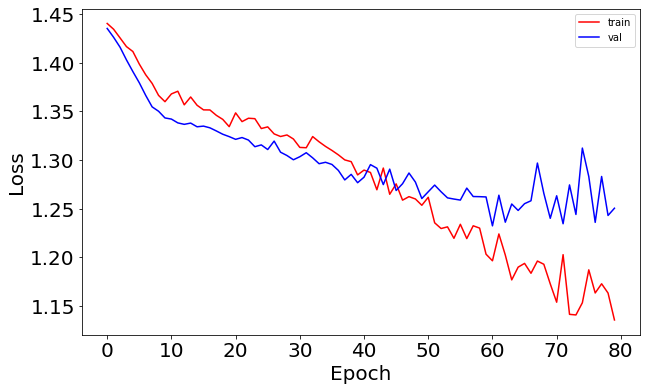

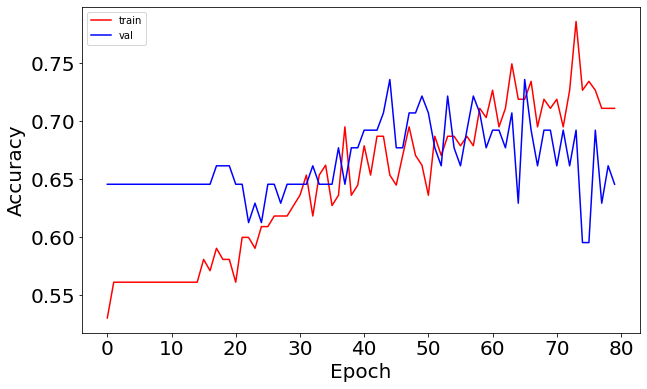

In [54]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model.history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model.history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model.history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(model.history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

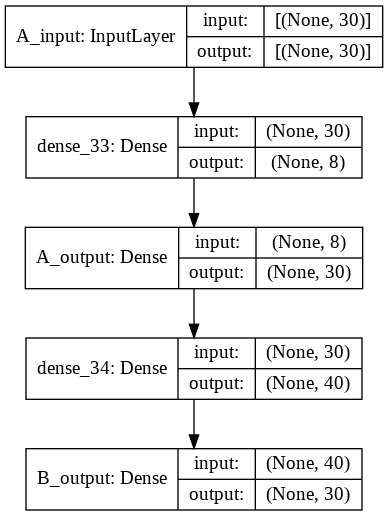

In [46]:
A1 = keras. Input(shape=(30,), name='A_input')
A2 = Dense(8, activation='relu')(A1)
A3 = Dense(30, activation='relu', name='A_output')(A2)


B2 = Dense(40, activation='relu')(A3)
B3 = Dense(30, activation='relu', name='B_output')(B2)

## define A
A = Model(inputs=A1, outputs=A3)

## define B
B = Model(inputs=A1, outputs=B3) 
keras.utils.plot_model(B, "Model.png", show_shapes=True)